An Ansatz for the Hubbard Model
===========================

Prerequisites: OpenFermion, Qiskit, SciPy (which will pull in NumPy), and matplotlib, e.g. install with pip:

`$ python -m pip install qiskit openfermion scipy matplotlib`

Introduction
--------------

This tutorial discusses possible Ansätze for use with the _Variational Quantum Eigensolver_ (VQE) algorithm to find the ground state for configurations of the __[Hubbard Model](hubbard_model_intro.ipynb)__ (HM). VQE uses a classical optimizer to suggest trial states and a quantum chip to calculate the expectation values of the Hamiltonian at those states. This process iterates, with the optimizer refining the trial state until a minimum is found, which provides an upper bound to the ground state of the Hamiltonian.

An _Ansatz_ is a parametrized description of quantum states, covering in effect a subset of the full Hilbert space. It is used in VQE to reduce the total search space by considering only those states that satisfy the constraints to which a potential solution has to conform, e.g. states that have the correct symmetries, number of particles, parity, etc. An Ansatz can also be used to simplify the problem: resolving symmetries can remove parameters, drop physical but unlikely solutions (e.g. those with higher excitations), or only restrict trial states to ones that can be easily constructed with the native gate set of the hardware. Such simplification may mean that the exact solution can not be found, because the Ansatz can not describe it. However, VQE by design provides an upper limit to the ground state, thus even an inexact solution can be useful, for example as a stepping stone to refinement of the problem specification.

Ansatz design is (still) an art and the best approach depends on the specific problem (e.g. because of its symmetries) and hardware used (e.g. because of connectivity or specialized gates). The discussion below is therefore meant to be read within the context of the Hubbard Model tutorial and whereas the methods can be applied to other problems, the conclusions are most certainly _not_ portable.

## Unitary Coupled Cluster Ansatz

The Unitary Coupled Cluster (UCC) Ansatz originates from the coupled cluster numerical method$^1$ as used in quantum chemistry. Electrons affect each other because they are negatively charged and like-charged particles repel. Their movements are thus correlated and can not be considered as independent. The coupled cluster method builds on multi-electron wave functions to capture the electron correlations and their effect on energy levels. Here, we consider only single (S) and double (D) excitations in the UCC Ansatz, or UCCSD for short:

<p>\begin{equation*}
    T(\vec{\theta}) = \sum_{ij} \theta_{ij} a_i^\dagger a_j + \frac{1}{2}\sum_{ijkl} \theta_{ijkl}a_i^\dagger a_j^\dagger a_k a_l
\end{equation*}
</p>

where $\vec{\theta}$ represents the vector of optimization parameters, describing amplitudes for the single (first sum) and double (second sum) excitations. Their interpretation is rather straightforward: single excitations are movements of single electrons from one occupied to one unoccupied site (compare the hopping term in the Hubbard Model); double excitations are correlated movements of two electrons from two occupied to two unoccupied sites.$^2$

The Ansatz is then implemented as an evolution operator, allowing an initial state of electrons in well defined positions $|\psi_0\rangle$, which is simple to construct (e.g. in the case of a Jordan-Wigner mapping, this is a simple matter of flipping a number of qubits equal to the number of electrons from the computational basis state $|0\rangle$ to $|1\rangle$ using an X-gate, see the __[Hubbard Model](hubbard_model_intro.ipynb)__ notebook), to evolve to the parametrized _trial wave function_:
<p>\begin{equation*}
    U(\vec{\theta}) |\psi_0\rangle = e^{i({T(\vec{\theta}) - T^\dagger(\vec{\theta})})}|\psi_0\rangle
\end{equation*}
</p>

Since all excitations are by design reversible (simply move the electrons back to the original sites), only a single step of size `1` needs to be considered in the construction of the evolution operator, with the parameters $\vec{\theta}$ capturing the precise evolution step size required to reach the ground state. When the expectation value of the Hamiltonian on a trial wave function, given some $\vec{\theta}$, reaches the global minimum, then that state represents (or is an upper bound to) the ground state.

### Qiskit UCCSD

The _general_ UCCSD Ansatz in Qiskit$^3$ constructs a circuit parametrized with rotation gates for the classical minimizer in VQE to optimize. As a practical matter, this general implementation is not a good match for the Hubbard Model used in this tutorial, because it does not capture all symmetries, resulting in more optimization parameters than necessary and in dependencies between the parameters. Such dependencies manifest themselves as saddle points in the localized surface as seen by the minimizer, because changes in one parameter can be undone with equivalent changes in another. Combined with their periodicity $(-\pi, \pi)$; all being rotations), saddle points become local minima where the minimizer can get trapped. (Note that this is much less of a problem for solving molecular problems as these usually have a good initial starting point from classical approximations.)

VQE Ansätze in Qiskit are designed as callbacks, with Qiskit taking over the main loop. This allows submission of the full algorithm (quantum _and_ classical) as a single job. However, within the context of this tutorial, it is more convenient to keep the loop and the Ansatz (in the form of an objective function) implementation accessible, such that it is easy to modify and see test in simulation. Thus, for purely practical reasons, a different approach here is preferred here.

If you're interested, however, a complete example implementation can be found __[here](hubbard_vqe_qiskit_ansatz.py)__. (Note that it requires the `qiskit_nature` package in addition to the prerequisites mentioned above.)

### OpenFermion UCCSD

The OpenFermion implementation of UCCSD lets the minimizer choose the amplitudes (as expressed in the equation above) directly, which captures the symmetries in the HM better, leading to fewer parameters. Note that the two approaches are mathematically equivalent, as the relative amplitudes are what matter, which in a circuit become relative phase differences, setup by rotations. The amplitudes are not periodic, which further greatly simplifies the optimization surface and simplifies the use of bounds.

In what follows, we will only use the OpenFermion implementation of UCCSD.

<div class="alert alert-block alert-info">
<b>Note:</b> Although there are some issues here specific to the HM, it is generally true that global searches in a multi-dimensional surface spanned with trigonometric functions are not easy on optimizers. Although the wavy patterns produced by such functions are beautiful and pleasing to the eye, there are many places for an optimizer to get stuck. Periodicity and especially NIQS-era noise only serve to make matters worse.
</div>

Objective Function
----------------------

The following couple of cells show how to construct an objective function from the Ansatz. This will be a simplified form of what is used in the included __[hubbard.py](hubbard.py)__ module (which provides caching, an optional noise model, BQSKit optimization, etc., etc.) in order to show and highlight the important structural elements and not be lost in the details.

An objective function is implemented as a callback that will receive a set of parameters ($\vec{\theta}$) from the optimizer and is expected to return a corresponding value (and possible an uncertainty estimate and/or an evaluation cost) to minimize. Here, the parameters are a set of amplitudes in the "packed" form that OpenFermion wants (a flat array of single excitation amplitudes, followed by the ones for double excitations). For convenience, to keep the interface the same such that this implementation can work with an optimizer, we pull in the other relevant parameters from the global space (see __[hubbard.py](hubbard.py)__ for an alternative implementation).

As a first step, create a Hubbard Model setup.

In [1]:
import hubbard as hb
import openfermion as of
import qiskit as qk
import numpy as np
import scipy

from matplotlib import pyplot as plt

# local version of the OpenFermion UCCSD Ansatz that works with Qiskit
import uccsd_evolution

In [2]:
# Select a model appropriate for the machine used:
#    laptop -> use small model
#    server -> use medium model

MODEL = hb.small_model
#MODEL = hb.medium_model

# Hubbard model for fermions (Fermi-Hubbard) required parameters
xdim, ydim, t, U, chem, magf, periodic, spinless = MODEL()

# Number of electrons to add to the system
n_electrons_up   = 1
n_electrons_down = 1
n_electrons = n_electrons_up + n_electrons_down

# Total number of "sites", with each qubit representing occupied or not
spinfactor = spinless and 1 or 2
n_qubits = n_sites = xdim * ydim * spinfactor

# Create the Hubbard Model for use with Qiskit
hubbard_op = hb.hamiltonian_qiskit(
    x_dimension        = xdim,
    y_dimension        = ydim,
    tunneling          = t,
    coulomb            = U,
    chemical_potential = chem,
    magnetic_field     = magf,
    periodic           = periodic,
    spinless           = spinless,
    fermion_transform  = 'jordan-wigner'
)

We will start with the simplest of objective implementations. The implementation details of the objective are taken as a given here, because this is done using Qiskit's _operator flow_ and thus highly specific to that framework. There is therefore little to be gained from constructing it as an exercise (unless you were trying to learn Qiskit). You should, however, be able to recognize the need for each of the parts and it may be useful, as an exercise, to identify their full implementations in the __[hubbard.py](hubbard.py)__ module.

First, setup the configuration, assuming the Jordan-Wigner transform will be used (`Step 1` in the next cell). Create a qubit register of the required number of qubits (taken from the Hamiltonian), then set the representative qubits to $1$ using an X-gate. That is, indices 0, 2, 4, etc. for the spin-up, and indices 1, 3, 5, etc. for the spin-down electrons:

```python
    reg = qk.QuantumCircuit(hubbard_op.num_qubits)
    for i in range(n_electrons_up):
        reg.x(i*2)
    for i in range(n_electrons_down):
        reg.x(i*2+1)
```

Next, in `Step 2`, we use OpenFermion to construct an evolution operator from the Ansatz, given the input parameters (`packed_amplitudes`, see description above), the number of qubits used, the number of electrons in the system, and the transform to use. In addition, the helper implementation in the __[uccsd_evolution.py](uccsd_evolution.py)__ module converts the result from OpenFermion `QubitOperator`s into Qiskit operator flow:

```python
    n_electrons = n_electrons_up + n_electrons_down
    evolution_op = uccsd_evolution.singlet_evolution(
                       packed_amplitudes, hubbard_op.num_qubits, n_electrons,
                       fermion_transform=of.transforms.jordan_wigner)
```

Note: spin is conserved by the singlet generator, which makes the implicit assumption that in filling, up and down indices alternate with up coming first. This behavior can be changed with helpers from the `of.utils.indexing` module (look for the `up_index` and `down_index` functions), e.g. if alternate labeling was used because of chip topology.

`Step 3` prepares the Hamiltonian operator to allow measurements, i.e. the calculation of expectation values. Note that it takes a short-cut: rather than splitting the components of the model into Pauli strings and computing them separately, the expectation value of the model is calculated in one step. This is a common approach in simulated examples (where the final state does not actually collapse on "measurement"), but this is of course not possible in reality. (See __[hubbard.py](hubbard.py)__ for the full component-based implementation.)

Finally, in `Step 4`, Qiskit's operator flow is used to do the actual expectation value calculation.

The final, full code is in the cell below.

In [3]:
def objective(packed_amplitudes):
  # Pull in the hamiltonian and its configuration
    global hubbard_op, n_electrons_up, n_electrons_down

  # Step 1: create the input state (Jordan-Wigner)
    reg = qk.QuantumCircuit(hubbard_op.num_qubits)
    for i in range(n_electrons_up):
        reg.x(i*2)
    for i in range(n_electrons_down):
        reg.x(i*2+1)

    input_state = qk.opflow.CircuitStateFn(reg)
        
  # Step 2: create the Ansatz operator from OpenFermion's UCCSD
    n_electrons = n_electrons_up + n_electrons_down
    evolution_op = uccsd_evolution.singlet_evolution(
                       packed_amplitudes, hubbard_op.num_qubits, n_electrons,
                       fermion_transform=of.transforms.jordan_wigner)
        
  # Step 3: create an observable from the Hamiltonian
    meas_op = qk.opflow.StateFn(hubbard_op, is_measurement=True)
        
  # Step 4: combine the parts and calculate the expectation
    expect_op = qk.opflow.PauliExpectation().convert(
                    meas_op @ evolution_op @ input_state
                )   
    energy = np.real(expect_op.eval())
    return energy

To try out the `objective` function, we need to figure out the number of parameters. This is fully determined by the Ansatz and thus in turn by the number and type of particles simulated (see the definition of $T(\vec{\theta})$ above). As explained in the UCCSD description, it is the implementation that determines how many symmetries are resolved and thus the final number of parameters. We are therefore reduced to asking the implementation for their number.

In [4]:
npar = uccsd_evolution.singlet_paramsize(n_qubits, n_electrons)
print('number of parameters used in the UCCSD Ansatz:', npar)

number of parameters used in the UCCSD Ansatz: 2


With the number of parameters known, an initial set can be created to play with; the exact values do not matter. We can also pull a pre-calculated solution from the model, to confirm that the objective function can generate the correct solution.

**Exercise:** evaluate the objective function with some randomly generated array of parameter values, and at the point returned by `MODEL.optimal(n_electrons_up, n_electrons_down, transform='jordan-wigner')`.

In [5]:
# random trial point
rng = np.random.default_rng(42)   # for reproducibility while debugging
trial_amplitudes = np.array(-0.05+0.1*rng.random(size=npar))
print('trial amplitudes:', trial_amplitudes)
print('objective at trial:', objective(trial_amplitudes))
print()

# classically calculated exact solution
print('exact solution:', hb.exact(hubbard_op, n_electrons_up, n_electrons_down))
print()

# value at optimal parameters
at_opt = MODEL.optimal(n_electrons_up, n_electrons_down, transform='jordan-wigner')
print('amplitudes at optimal:', at_opt)
print('objective at optimal:', objective(at_opt))

trial amplitudes: [ 0.0273956  -0.00611216]
objective at trial: 2.107214744858958

exact solution: -1.2360679774997896

amplitudes at optimal: [-0.86866234  0.18526051]
objective at optimal: -1.2360679602264795


**Optional Exercise:** scan the region around the optimal parameters to show that it is indeed a minimum.

**Exercise:** use the above objective function to solve the constructed Hubbard Model, for example using `scipy.optimize` (https://docs.scipy.org/doc/scipy/reference/optimize.html). Compare your results with the pre-calculated ones. Below is another possible example, based on Qiskit.

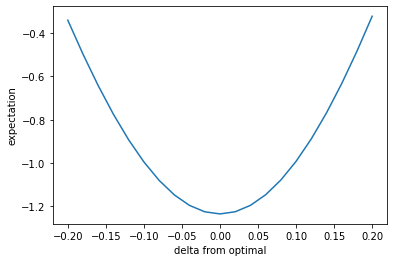

SciPy:       fun: -1.236067977499692
 hess_inv: array([[ 0.07777045, -0.03509061],
       [-0.03509061,  0.0754631 ]])
      jac: array([-1.43051147e-06, -1.38580799e-06])
  message: 'Optimization terminated successfully.'
     nfev: 27
      nit: 7
     njev: 9
   status: 0
  success: True
        x: array([-0.86866482,  0.18521654])
Qiskit: (array([-0.86866234,  0.18526051]), -1.2360679602303217, 40)


In [6]:
# Optional Exercise: calculate the objective at offsets from optimal
d_offset = 0.02
n_offsets = 21

plt.figure()
plt.xlabel('delta from optimal')
plt.ylabel('expectation')

X = [d_offset*(i-n_offsets//2) for i in range(n_offsets)]
y = [objective(at_opt+x) for x in X]

plt.plot(X, y)
plt.show()

# SciPy solution
result = scipy.optimize.minimize(objective, trial_amplitudes, method='BFGS')
print('SciPy:', result)

# Alternative, use Qiskit; see its documentation for more:
#   https://qiskit-community.github.io/qiskit-translations/id_ID/stubs/qiskit.algorithms.optimizers.html
from qiskit.algorithms.optimizers import COBYLA

optimizer = COBYLA(maxiter=100)

optimizer = COBYLA(maxiter=100)
result = optimizer.minimize(objective, trial_amplitudes)

print('Qiskit:', result)

Unfortunately, this is not enough. In order to create a circuit to execute on a quantum computer, the matrix exponentials in the evolution operator need to be approximated. For this, a process called _Trotterization_$^{4,5}$ is used. Although we are not considered with time evolution here, the principles are the same for evolution from the computational zero state to the intended trial state.$^{6}$ That is, the evolution is approximated using a number of steps ("time slices").

Since Trotterization is a basic and common operation, Qiskit operation flow provides it for use. With trotterization, the `objective` becomes as follows (we're adding the number of Trotter steps as an argument for the next exercise).

In [7]:
def objective(packed_amplitudes, trotter_steps=2):
  # Pull in the hamiltonian and its configuration
    global hubbard_op, n_electrons_up, n_electrons_down

  # Step 1: create the input state (Jordan-Wigner)
    reg = qk.QuantumCircuit(hubbard_op.num_qubits)
    for i in range(n_electrons_up):
        reg.x(i*2)
    for i in range(n_electrons_down):
        reg.x(i*2+1)

    input_state = qk.opflow.CircuitStateFn(reg)
        
  # Step 2: create the Ansatz operator from OpenFermion's UCCSD
    n_electrons = n_electrons_up + n_electrons_down
    evolution_op = uccsd_evolution.singlet_evolution(
                       packed_amplitudes, hubbard_op.num_qubits, n_electrons,
                       fermion_transform=of.transforms.jordan_wigner)

  # Step 2a: Trotterize the Ansatz operator
    trotterized_ev_op = qk.opflow.PauliTrotterEvolution(
        trotter_mode='trotter', reps=trotter_steps).convert(evolution_op)

  # Step 3: create an observable from the Hamiltonian
    meas_op = qk.opflow.StateFn(hubbard_op, is_measurement=True)
        
  # Step 4: combine the parts and calculate the expectation (note the ev_op update)
    expect_op = qk.opflow.PauliExpectation().convert(
                    meas_op @ trotterized_ev_op @ input_state
                )   
    energy = np.real(expect_op.eval())
    return energy

**Exercise:** scan the region around the optimal parameters. Do this for 1-4 Trotter steps. Plot the results. What is the conclusion?

Trotter step 1 done
Trotter step 2 done
Trotter step 3 done
Trotter step 4 done
Trotter step 5 done


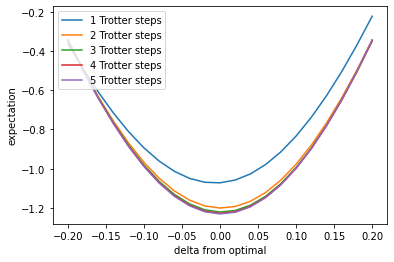

In [8]:
# adjust the number of offsets from optimal as needed and evaluate the
# objective at those offsets (as an alternate, modify the code to change
# only a single parameter at a time, rather than all); run over different
# ranges of Trotter steps and figure a reasonable number
d_offset = 0.02
n_offsets = 21
n_trotter_steps = 5

plt.figure()
plt.xlabel('delta from optimal')

X = [d_offset*(i-n_offsets//2) for i in range(n_offsets)]

for t in range(1, n_trotter_steps+1):
    y = []
    for x in X:
        y.append(objective(at_opt+x, t))
    plt.plot(X, y, label='%s Trotter steps' % t)
    print('Trotter step %d done' % t)

plt.legend(loc='upper left')
plt.ylabel('expectation')
plt.show()

If the produced plot is correct, then there are two important conclusions to be made here:

   1. A single Trotter step is insufficient to accurately calculate the minimum: at least 3 are needed. However, there is a trade-off as each additional Trotter steps greatly increases the depth of the circuit. As we will see in the __[Effect of Noise on VQE](hubbard_vqe_noise.ipynb)__ notebook, increased depth will "lift" the expectation value due to added noise, counter-acting the benefit of the extra Trotter step.
   
   2. The optimal parameters for each are reasonably close, meaning that we can safely solve the problem for fewer Trotter steps first (with the benefit of less noise, because of shorter circuits), then refine.

References
-------------

[1] https://en.wikipedia.org/wiki/Coupled_cluster
<br>[2] Xu et al., "Test of the unitary coupled-cluster variational quantum eigensolver for a simple strongly correlated condensed-matter system", Mod. Phys. Lett. B, Vol. 34, Nos. 19 & 20 (2020)
<br>[3] https://qiskit.org/textbook/ch-applications/vqe-molecules.html#VQE-Implementation-in-Qiskit
<br>[4] H.F. Trotter, "On the product of semi-groups of operators" Proc. Am. Math. Phys., 10:545, 1959
<br>[5] M. Suzuki, "Improved Trotter-like formula", Phys. Lett. A, 180(3):232 – 234, 1993
<br>[6] https://arxiv.org/abs/1004.5528, K.L. Brown, et al.,, "Using Quantum Computers for Quantum Simulation"